При написании кода я опирался на семинар по трансформерам и на эти ресурсы:
- https://sungwookyoo.github.io/tips/study/Multihead_Attention/ (маски для MultiheadAttention);
- https://pytorch.org/tutorials/beginner/transformer_tutorial.html (PositionalEncoding).

In [1]:
from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


In [2]:
import zipfile
zipfile.ZipFile('./drive/MyDrive/ber-eng.zip', 'r').extractall('./')

In [3]:
import unicodedata
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.legacy.data import Field, BucketIterator
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
def is_tifinagh(x):
    return unicodedata.name(x)[:len('TIFINAGH LETTER')] == 'TIFINAGH LETTER'

In [5]:
with open('ber.txt', 'r') as inf, open('data.txt', 'w') as ouf:
    predata = inf.read()
    phrases = [line.lower().split('\t')[:-1] for line in predata.split('\n')[:-1]]
    cleaned_phrases = ['\t'.join(phrases[0])]
    key = phrases[0][0]
    for i in range(1, len(phrases)):
        if phrases[i][0] != key and not is_tifinagh(phrases[i][1][0]):
            cleaned_phrases += ['\t'.join(phrases[i])]
            key = phrases[i][0]
    random.shuffle(cleaned_phrases)
    data = '\n'.join(cleaned_phrases)
    ouf.write(data)

In [6]:
with open('en_for_bpe.txt', 'w') as enf, open('be_for_bpe.txt', 'w') as bef:
    en_words = [line.split('\t')[0] for line in cleaned_phrases]
    be_words = [line.split('\t')[1] for line in cleaned_phrases]
    enf.write('\n'.join(en_words))
    bef.write('\n'.join(be_words))

In [7]:
!pip install youtokentome

     |████████████████████████████████| 1.7 MB 26.8 MB/s 


In [8]:
from youtokentome import BPE

In [9]:
bpe_en = BPE.train(data='en_for_bpe.txt', vocab_size=15000, model='bpe_en.bin')
bpe_be = BPE.train(data='be_for_bpe.txt', vocab_size=15000, model='bpe_be.bin')

In [10]:
def tokenize_en(x, tokenizer=bpe_en):
    return [tokenizer.id_to_subword(word) for word in tokenizer.encode(x)]

def tokenize_be(x, tokenizer=bpe_be):
    return [tokenizer.id_to_subword(word) for word in tokenizer.encode(x)]

In [11]:
SRC = Field(tokenize=tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize=tokenize_be,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

dataset = torchtext.legacy.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [12]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [13]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [15]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 31.5 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 6.8 MB 68.1 MB/s 
     |████████████████████████████████| 895 kB 68.7 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
from transformers import get_linear_schedule_with_warmup

In [17]:
from gensim.models import Word2Vec

source = [example.src for example in train_data.examples]
target = [example.trg for example in train_data.examples]

en_word_list = [SRC.unk_token, SRC.init_token, SRC.pad_token, SRC.eos_token]
en_vector_list = [np.random.rand(256) for i in range(4)]
en_w2v = Word2Vec(source, size=256, min_count=1, window=15)
en_w2v.wv.add(en_word_list, en_vector_list)
en_w2v.save('en_w2v.model')

be_word_list = [TRG.unk_token, TRG.init_token, TRG.pad_token, TRG.eos_token]
be_vector_list = [np.random.rand(256) for i in range(4)]
be_w2v = Word2Vec(target, size=256, min_count=1, window=15)
be_w2v.wv.add(be_word_list, be_vector_list)
be_w2v.save('be_w2v.model')

en_emb_weights = torch.FloatTensor(np.array([en_w2v.wv[SRC.vocab.itos[i]] for i in range(len(SRC.vocab))]))
be_emb_weights = torch.FloatTensor(np.array([be_w2v.wv[TRG.vocab.itos[i]] for i in range(len(TRG.vocab))]))

In [18]:
class EncoderBlock(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout):

        super().__init__()

        self.attn = nn.MultiheadAttention(hid_dim, n_heads, dropout=dropout, batch_first=True)
        self.attn_norm = nn.LayerNorm(hid_dim)
        self.fc1 = nn.Linear(hid_dim, 2 * hid_dim)
        self.fc2 = nn.Linear(2 * hid_dim, hid_dim)
        self.ff_norm = nn.LayerNorm(hid_dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self, src, src_pad_mask, src_attn_mask):

        x, _ = self.attn(src, src, src, key_padding_mask=src_pad_mask, attn_mask=src_attn_mask)
        src = self.attn_norm(src + self.dropout(x))
        fc1 = torch.relu(self.fc1(src))
        fc2 = self.fc2(self.dropout(fc1))
        src = self.ff_norm(src + self.dropout(fc2))
        return src

In [19]:
class Encoder(nn.Module):

    def __init__(self, hid_dim, n_heads, n_layers, batch_size, max_len, dropout):

        super().__init__()

        self.emb = nn.Embedding.from_pretrained(en_emb_weights, freeze=False)

        position = torch.arange(max_len).unsqueeze(1)
        freq = torch.exp(-torch.arange(hid_dim // 2) * 2 / hid_dim * torch.log(torch.FloatTensor([10000])))
        pos_enc = torch.zeros(max_len, 1, hid_dim)
        pos_enc[:, 0, 0::2] = torch.sin(position * freq)
        pos_enc[:, 0, 1::2] = torch.cos(position * freq)
        self.pos_enc = pos_enc.repeat(1, batch_size, 1).permute(1, 0, 2).contiguous().to(device)

        self.encoder = nn.ModuleList([EncoderBlock(hid_dim, n_heads, dropout) for i in range(n_layers)])

        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)


    def forward(self, src, src_pad_mask, src_attn_mask):

      src = self.dropout(self.emb(src) * self.scale + self.pos_enc[:src.size(0),:src.size(1),:])

      for block in self.encoder:
          src = block(src, src_pad_mask, src_attn_mask)

      return src

In [20]:
class DecoderBlock(nn.Module):

    def __init__(self, hid_dim, n_heads, dropout):

        super().__init__()
    
        self.dec_attn = nn.MultiheadAttention(hid_dim, n_heads, dropout=dropout, batch_first=True)
        self.dec_attn_norm = nn.LayerNorm(hid_dim)
        self.cross_attn = nn.MultiheadAttention(hid_dim, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn_norm = nn.LayerNorm(hid_dim)
        self.fc1 = nn.Linear(hid_dim, 2 * hid_dim)
        self.fc2 = nn.Linear(2 * hid_dim, hid_dim)
        self.ff_norm = nn.LayerNorm(hid_dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self, trg, trg_pad_mask, trg_attn_mask, src, cross_pad_mask, cross_attn_mask):
        
        x, _ = self.dec_attn(trg, trg, trg, key_padding_mask=trg_pad_mask, attn_mask=trg_attn_mask)
        trg = self.dec_attn_norm(self.dropout(x) + trg)
        x, attn = self.cross_attn(trg, src, src, key_padding_mask=cross_pad_mask, attn_mask=cross_attn_mask)
        trg = self.cross_attn_norm(self.dropout(x) + trg)
        fc1 = torch.relu(self.fc1(trg))
        fc2 = self.fc2(self.dropout(fc1))
        trg = self.ff_norm(trg + self.dropout(fc2))
        return trg, attn

In [21]:
class Decoder(nn.Module):

    def __init__(self, out_dim, hid_dim, n_heads, n_layers, batch_size, max_len, dropout):

        super().__init__()

        self.emb = nn.Embedding.from_pretrained(be_emb_weights, freeze=False)

        position = torch.arange(max_len).unsqueeze(1)
        freq = torch.exp(-torch.arange(hid_dim // 2) * 2 / hid_dim * torch.log(torch.FloatTensor([10000])))
        pos_enc = torch.zeros(max_len, 1, hid_dim)
        pos_enc[:, 0, 0::2] = torch.sin(position * freq)
        pos_enc[:, 0, 1::2] = torch.cos(position * freq)
        self.pos_enc = pos_enc.repeat(1, batch_size, 1).permute(1, 0, 2).contiguous().to(device)

        self.decoder = nn.ModuleList([DecoderBlock(hid_dim, n_heads, dropout) for i in range(n_layers)])

        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

        self.out = nn.Linear(hid_dim, out_dim)


    def forward(self, trg, trg_pad_mask, trg_attn_mask, src, cross_pad_mask, cross_attn_mask):

        trg = self.dropout(self.emb(trg) * self.scale + self.pos_enc[:trg.size(0),:trg.size(1),:])

        for block in self.decoder:
            trg, attn = block(trg, trg_pad_mask, trg_attn_mask, src, cross_pad_mask, cross_attn_mask)

        return self.out(trg), attn

In [22]:
class Transformer(nn.Module):

    def __init__(self, out_dim, hid_dim, n_heads, n_layers, dropout, batch_size, src_pad, trg_pad, max_len=1000):

        super().__init__()

        self.src_pad = src_pad
        self.trg_pad = trg_pad
        self.encoder = Encoder(hid_dim, n_heads, n_layers, batch_size, max_len, dropout)
        self.decoder = Decoder(out_dim, hid_dim, n_heads, n_layers, batch_size, max_len, dropout)
        
    
    def make_pad_mask(self, x, pad_id):

        return (x == pad_id)


    def make_attn_mask(self, x_size, y_size, mode):

        if mode == 'src':
            return torch.ones(x_size, y_size)
        else:
            mask = torch.triu(torch.ones(x_size, y_size), diagonal=1)
            mask[mask.bool()] = -float('inf')
            return mask

    
    def forward(self, src, trg):

        s = src.size(1)
        t = trg.size(1)
        src_pad_mask = self.make_pad_mask(src, self.src_pad).to(device)
        cross_pad_mask = self.make_pad_mask(src, self.src_pad).to(device)
        trg_pad_mask = self.make_pad_mask(trg, self.trg_pad).to(device)
        src_attn_mask = self.make_attn_mask(s, s, 'src').to(device)
        cross_attn_mask = self.make_attn_mask(t, s, 'cross').to(device)
        trg_attn_mask = self.make_attn_mask(t, t, 'trg').to(device)

        enc_src = self.encoder(src, src_pad_mask, src_attn_mask)
        output, attention = self.decoder(trg, trg_pad_mask, trg_attn_mask, enc_src, cross_pad_mask, cross_attn_mask)
        return output, attention

In [23]:
SRC_PAD = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD = TRG.vocab.stoi[TRG.pad_token]
INP_DIM = len(SRC.vocab)
OUT_DIM = len(TRG.vocab)
HID_DIM = 256
N_LAYERS = 3
N_HEADS = 8
DROPOUT = 0.1

trans = Transformer(OUT_DIM,
                    HID_DIM,
                    N_HEADS,
                    N_LAYERS,
                    DROPOUT,
                    BATCH_SIZE,
                    SRC_PAD,
                    TRG_PAD).to(device)

def init_weights(m):
    if type(m) != nn.Embedding:
        for name, param in m.named_parameters():
            nn.init.uniform_(param, -0.08, 0.08)

trans.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (emb): Embedding(12842, 256)
    (encoder): ModuleList(
      (0): EncoderBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (attn_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (attn_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (ff

In [24]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import time
import math

In [25]:
# 25 эпох - это явный перебор, но решил оставить так, потому что подбор параметров - не самоцель (ну и потому что уже скачал веса)
# к тому же БЛЕУ для весов best-val-model оказалось хуже, чем для весов на последней эпохе 
NUM_EPOCHS = 25

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD)
optimizer = optim.Adam(trans.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=5e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 7000, 22800)

def train(model, iterator, optimizer, scheduler, criterion, CLIP, train_history, valid_history):
    
    model.train()

    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output, attention = model(src, trg[:,:-1])
        output = output.contiguous().view(-1, OUT_DIM)
        trg = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()

    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, attention = model(src, trg[:,:-1])

            output = output.contiguous().view(-1, OUT_DIM)
            trg = trg[:,1:].contiguous().view(-1)
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

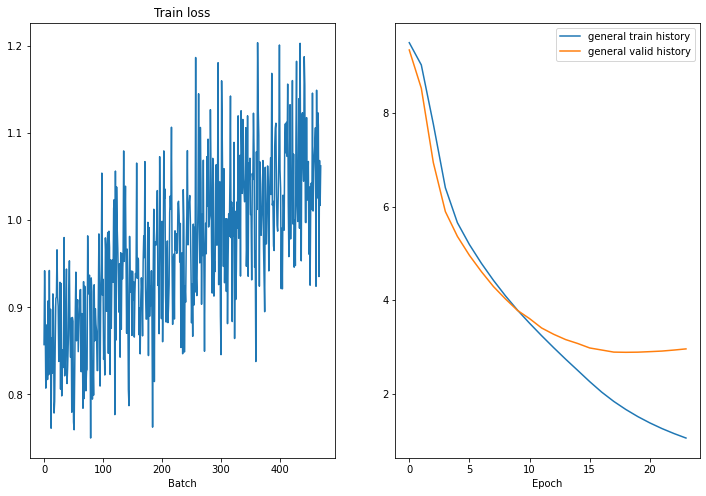

Epoch: 25 | Time: 0m 42s
	Train Loss: 0.967 | Train PPL:   2.629
	 Val. Loss: 2.991 | Val. PPL:  19.905


In [28]:
train_history = []
valid_history = []

CLIP = 5
best_valid_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = train(trans, train_iterator, optimizer, scheduler, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(trans, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(trans.state_dict(), 'best-val-model.pt')
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')   
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

In [29]:
torch.save(trans.state_dict(), 'last-val-model.pt')

In [30]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        tokens = [bpe_en.id_to_subword(token) for token in bpe_en.encode(sentence.lower())]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_pad_mask = model.make_pad_mask(src_tensor, model.src_pad).to(device)

    src_attn_mask = model.make_attn_mask(src_tensor.size(1), src_tensor.size(1), 'src').to(device)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_pad_mask, src_attn_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_pad_mask = model.make_pad_mask(trg_tensor, model.trg_pad).to(device)

        trg_attn_mask = model.make_attn_mask(trg_tensor.size(1), trg_tensor.size(1), 'trg').to(device)

        cross_pad_mask = model.make_pad_mask(src_tensor, model.src_pad).to(device)

        cross_attn_mask = model.make_attn_mask(trg_tensor.size(1), src_tensor.size(1), 'cross').to(device)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, trg_pad_mask, trg_attn_mask, enc_src, cross_pad_mask, cross_attn_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes][1:-1]

    result = ''.join(trg_tokens)
    
    return result.replace('▁', ' '), attention

In [31]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['▁i', '▁wish', "▁you'd", '▁told', '▁me', '▁this', '▁earlier.']
trg = ['▁mennaɣ', '▁mer', '▁iyi-d-tenniḍ', '▁aya', '▁uqbel.']


In [32]:
translation, attention = translate_sentence(src, SRC, TRG, trans, device)

print(f'predicted trg = {translation}')

predicted trg =  mennaɣ lemmer iyi-d-tennid aya uqbel.


In [33]:
translation, attention = translate_sentence("I have a dog", SRC, TRG, trans, device)

print(f'predicted trg = {translation}')

predicted trg =  sɛiɣ aydi ad d-yadef.


In [34]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_pad_mask(src_tensor, SRC.vocab.stoi[SRC.pad_token]).to(device)
    sa = model.make_attn_mask(src_tensor.size(1), src_tensor.size(1), 'src').to(device)


    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask, sa)

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_pad_mask(trg_tensor, TRG.vocab.stoi[TRG.pad_token]).to(device)
        ta = model.make_attn_mask(trg_tensor.size(1), trg_tensor.size(1), 'trg').to(device)
        cross_pad_mask = model.make_pad_mask(src_tensor, SRC.vocab.stoi[SRC.pad_token]).to(device)
        cross_attn_mask = model.make_attn_mask(trg_tensor.size(1), src_tensor.size(1), 'cross').to(device)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, trg_mask, ta, enc_src, cross_pad_mask, cross_attn_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [35]:
from torchtext.data.metrics import bleu_score
from tqdm.notebook import tqdm

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in tqdm(iterator):
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                for i in sentence[1:]:
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            for sent in pred_trg:
                sent = [token for token in sent if token != '<unk>']
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)

In [36]:
_, _, bleu_score = calculate_bleu_alt(test_iterator, SRC, TRG, trans, device)

print(f'BLEU score = {bleu_score*100:.2f}')

  0%|          | 0/89 [00:00<?, ?it/s]

BLEU score = 22.26


In [37]:
torch.save(SRC.vocab, 'src_vocab.pth')
torch.save(TRG.vocab, 'trg_vocab.pth')

Таким образом, эмбеддинги с предобученными весами дали ВLEU чуть хуже, чем обученные с нуля.